# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

## Project Overview

This project manipulates large and realistic datasets with Spark to engineer relevant features for predicting churn. This project uses Spark MLlib to build machine learning models with large datasets.

In [33]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, IntegerType
from pyspark.sql.functions import desc, asc, udf
from pyspark.sql.functions import sum as Fsum
from pyspark.sql import SQLContext
from sklearn.metrics import confusion_matrix

from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator



import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [34]:
# Create spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()


# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

The data is also available "s3n://udacity-dsnd/sparkify/mini_sparkify_event_data.json"

In [35]:
# Read in full sparkify dataset
event_data = "mini_sparkify_event_data.json"   
df = spark.read.json(event_data)
df.toPandas().head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### Preliminary Data Exploration 

In [36]:
df.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

In [37]:
print(df.count()), print(len(df.columns))

286500
18


(None, None)

### Data Types of Columns

In [38]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [39]:
df.select("auth").dropDuplicates().show()

+----------+
|      auth|
+----------+
|Logged Out|
| Cancelled|
|     Guest|
| Logged In|
+----------+



In [40]:
df.select("length").describe().show()

+-------+-----------------+
|summary|           length|
+-------+-----------------+
|  count|           228108|
|   mean|249.1171819778458|
| stddev|99.23517921058361|
|    min|          0.78322|
|    max|       3024.66567|
+-------+-----------------+



In [41]:
df.select("level").dropDuplicates().sort("level").show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [42]:
df.select("status").dropDuplicates().sort("status").show(50)

+------+
|status|
+------+
|   200|
|   307|
|   404|
+------+



In [43]:
df.select("page").dropDuplicates().sort("page").show(50)

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



In [44]:
df.select("userID").dropDuplicates().sort("userID").show(5)

+------+
|userID|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
+------+
only showing top 5 rows



There are some rows with userID being null. These users are probabaly not registered users. We will drop these recods

### Drop Rows with Missing Values

In [45]:
df_valid = df.dropna(how = "any", subset = ["userId", "sessionId"])
df_valid.count()

286500

In [46]:
#df_valid.select("userId").dropDuplicates().sort("userId").show()

In [47]:
df_valid = df_valid.filter(df_valid["userId"] != "")
df_valid.count()

278154

## Define Churn
Once you've done some preliminary analysis, create a column Churn to use as the label for your model. I suggest using the Cancellation Confirmation events to define your churn, which happen for both paid and free users. 
As a bonus task, you can also look into the Downgrade events.


### Users Downgrade Their Accounts

Find when users downgrade their accounts and then flag those log entries. Then use a window function and cumulative sum to distinguish each user's data as either pre or post downgrade events.

In [48]:
df_valid.filter("page = 'Cancellation Confirmation'").show(3)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Cancelled|   Adriel|     M|          104| Mendoza|  null| paid|  Kansas City, MO-KS|   GET|Cancellation Conf...|1535623466000|      514|null|   200|1538943990000|"Mozilla/5.0 (Mac...|    18|
|  null|Cancelled|    Diego|     M|           56|   Mckee|  null| paid|Phoenix-Mesa-Scot...|   GET|Cancellation Conf...|1537167593000|      540|null|   200|1539033046000|"Mozilla/5.0 (iPh...|    32|
|  nu

In [49]:
flag_cancel_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df_valid = df_valid.withColumn("Cancelled", flag_cancel_event("page"))

In [50]:
from pyspark.sql import Window
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

In [51]:
#df_valid = df_valid.withColumn("phase", Fsum("downgraded").over(windowval))
df_valid = df_valid.withColumn("Churn", Fsum("Cancelled").over(windowval))

In [52]:
df_valid.groupby("Churn").count().show()

+-----+------+
|Churn| count|
+-----+------+
|    0|233290|
|    1| 44864|
+-----+------+



## Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### Gender ratio in Churned users

In [53]:
df_valid.select("gender", "userId", "churn").dropDuplicates().groupby("Churn", "gender").count().show()

+-----+------+-----+
|Churn|gender|count|
+-----+------+-----+
|    0|     F|   84|
|    1|     M|   32|
|    1|     F|   20|
|    0|     M|   89|
+-----+------+-----+



In [54]:
print( "The ratio of female users in churned users:", round(20/(20+32), 2) )
print( "The ratio of female users in stayed users:", round(84/(84+89), 2) )

The ratio of female users in churned users: 0.38
The ratio of female users in stayed users: 0.49


### Calculating Statistics by Hour

In [55]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)
df_valid = df_valid.withColumn("hour", get_hour(df.ts))

In [56]:
df_features = df_valid.filter(df_valid.page == "NextSong").groupby("userId", "Churn").pivot("hour").agg({'page':'count'}).sort("Churn")

In [57]:
df_features = df_features.fillna(0).toPandas()
df_features.sample(20)

,userId,Churn,0,1,10,11,12,13,14,15,...,21,22,23,3,4,5,6,7,8,9
90,200005,0,10,0,0,2,15,16,18,13,...,0,13,17,0,0,0,0,9,6,0
178,51,1,86,92,70,70,48,73,87,90,...,116,97,100,101,109,90,84,80,65,57
153,113,0,50,60,46,46,73,105,103,114,...,46,44,43,61,51,42,29,23,26,42
53,44,0,27,16,19,22,14,14,16,26,...,23,28,32,15,15,15,13,16,14,14
201,58,1,70,65,87,81,92,107,76,71,...,73,68,74,71,76,65,60,51,57,83
11,78,0,5,3,9,13,17,5,0,0,...,15,27,25,15,21,22,3,10,16,14
51,200025,0,30,21,16,37,42,15,26,76,...,35,29,31,27,30,29,31,22,9,0
165,65,0,62,70,87,93,91,109,102,87,...,109,86,58,58,83,91,106,101,92,87
111,300010,0,29,15,0,4,0,19,36,39,...,6,16,23,0,0,0,0,0,0,0
21,107,0,15,14,0,9,6,11,0,0,...,15,14,14,13,29,27,29,28,0,0


In [58]:
stay_songs_in_hour= df_valid.filter(df_valid.Churn == 0).filter(df_valid.page == "NextSong").groupby(df_valid.hour).count().orderBy(df_valid.hour.cast("float"))

In [59]:
churn_songs_in_hour= df_valid.filter(df_valid.Churn == 1).filter(df_valid.page == "NextSong").groupby(df_valid.hour).count().orderBy(df_valid.hour.cast("float"))

In [60]:
num_churn_users = df_valid.filter(df_valid.Churn == 1).select("userID").dropDuplicates().count()
num_churn_users

52

In [61]:
num_stay_users = df_valid.filter(df_valid.Churn == 0).select("userID").dropDuplicates().count()
num_stay_users

173

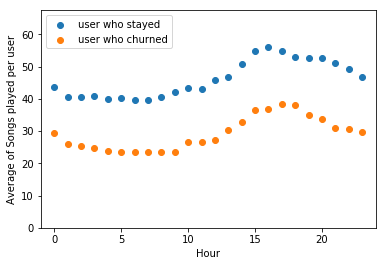

In [62]:
stay_songs_in_hour_pd = stay_songs_in_hour.toPandas()
stay_songs_in_hour_pd.hour = pd.to_numeric(stay_songs_in_hour_pd.hour)


churn_songs_in_hour_pd = churn_songs_in_hour.toPandas()
churn_songs_in_hour_pd.hour = pd.to_numeric(churn_songs_in_hour_pd.hour)

plt.scatter(stay_songs_in_hour_pd["hour"], stay_songs_in_hour_pd["count"]/num_stay_users, label='user who stayed')
plt.scatter(churn_songs_in_hour_pd["hour"], churn_songs_in_hour_pd["count"]/num_churn_users, label= 'user who churned')

plt.legend()
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(stay_songs_in_hour_pd["count"]/num_stay_users))
plt.xlabel("Hour")
plt.ylabel("Average of Songs played per user");

# Feature Engineering

Once you've familiarized yourself with the data, build out the features you find promising to train your model on. 


In [63]:
Gender_indexer = StringIndexer(inputCol="gender", outputCol='Gender_Index')
Page_indexer = StringIndexer(inputCol="page", outputCol='Page_Index')

Gender_encoder = OneHotEncoder(inputCol='Gender_Index', outputCol='Gender_Vec')
Page_encoder = OneHotEncoder(inputCol='Page_Index', outputCol='Page_Vec')

assembler = VectorAssembler(inputCols=[ "Gender_Vec",  "Page_Vec" ], outputCol="features")

#scaler = StandardScaler()\
#.setInputCol("features")\
#.setOutputCol ()
indexer = StringIndexer(inputCol="Churn", outputCol="label")

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [64]:
train, test = df_valid.randomSplit([0.8, 0.2], seed=42)

In [65]:
lr = LogisticRegression(maxIter = 10, regParam=0.0, elasticNetParam=0)

pipeline = Pipeline(stages=[Gender_indexer, Page_indexer, Gender_encoder, Page_encoder, assembler, indexer, lr])
evaluator = BinaryClassificationEvaluator()

In [66]:
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam,[0.01, 2.0 ]) \
    .addGrid(lr.elasticNetParam, [0.0, 1.0])\
    .addGrid(lr.maxIter, [1, 10])\
    .build()


crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator= evaluator,
                          numFolds=3)

In [67]:
cvModel = crossval.fit(train)

In [68]:
cvModel.avgMetrics

[0.5831860213997937,
 0.582904408009128,
 0.5799251236781935,
 0.5799243641990828,
 0.5831860213997937,
 0.5831837150999143,
 0.5,
 0.5]

### Best Model Performance

In [69]:
results = cvModel.transform(test)

print('Best Model Test Area Under ROC', evaluator.evaluate(results))

Best Model Test Area Under ROC 0.5781407435670197


In [70]:
results.select('label', 'features', 'rawPrediction', 'prediction', 'probability').toPandas().head()


,label,features,rawPrediction,prediction,probability
0,0.0,"(1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.92138028845, -1.92138028845]",0.0,"[0.872292274722, 0.127707725278]"
1,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.12382091209, -2.12382091209]",0.0,"[0.89319697776, 0.10680302224]"
2,0.0,"(1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.92138028845, -1.92138028845]",0.0,"[0.872292274722, 0.127707725278]"
3,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[1.625840061, -1.625840061]",0.0,"[0.835598971618, 0.164401028382]"
4,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[1.625840061, -1.625840061]",0.0,"[0.835598971618, 0.164401028382]"


In [71]:
accuracy = results.filter(results.label == results.prediction).count() / results.count()

print("Accuracy :", accuracy)

Accuracy : 0.8396528753015736


### Best Model Parameters

In [72]:

cvModel.getEstimatorParamMaps()[ np.argmax(cvModel.avgMetrics) ]
print ('Best Param (regParam): 0.01')
print ('Best Param (elasticNetParam): 0.0')
print ('Best Param (MaxIter): 10')


Best Param (regParam): 0.01
Best Param (elasticNetParam): 0.0
Best Param (MaxIter): 10


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.